# **CONNECT GDRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **IMPORT LIBRARY**

In [ ]:
import nltk
import string
import re
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.svm import SVC
import time
from collections import Counter

#Tokenizing
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **READ DATA**

In [ ]:
import pandas as pd

data_raw = pd.read_excel('/content/gdrive/MyDrive/Skripsi/Dataset/dataset_fix.xlsx')

In [ ]:
data_raw

date        username  \
0     2022-06-29 23:59:34+00:00      tempodotco   
1     2022-06-29 23:59:18+00:00        butoable   
2     2022-06-29 23:57:06+00:00   crimsonandivy   
3     2022-06-29 23:54:17+00:00    KasanMulyono   
4     2022-06-29 23:53:37+00:00  edy_siregar_77   
...                         ...             ...   
2495  2022-06-29 09:08:22+00:00       ppaprikah   
2496  2022-06-29 09:06:23+00:00        963RPKFM   
2497  2022-06-29 09:06:19+00:00      kompasiana   
2498  2022-06-29 08:18:32+00:00       Bisniscom   
2499  2022-06-29 09:05:44+00:00          rachwz   

                                                content sentiment  
0     PKS Kritik Beli Pertalite Pakai MyPertamina, A...  negative  
1     Terpaksa harus uninstal ini instagram, soalnya...  negative  
2     Potret akibat dari pemerintah Indonesia yang b...  negative  
3     Per 1 Juli 2022 Pertamina buka pendaftaran di ...  positive  
4     Bukannya belajar dari kesalahan masa lalu, pem...  negative  
...                                                 ...       ...  
2495  Oh jadi soal beli solar dan pertalite pakai ap...  positive  
2496  Halo Sahabat RPKüëãPT Pertamina melalui anak usa...  positive  
2497  Aplikasi MyPertamina, Langkah Maju Menuju Sist...  positive  
2498  DPR Dukung Penggunaan MyPertamina untuk Beli P...  positive  
2499  MyPertamina di profil harus isi hobi tuh fungs...  negative  

[2500 rows x 4 columns]

# **EXPLORASI DATA**

In [ ]:
print(data_raw["sentiment"].value_counts())

negative    1499
positive    1001
Name: sentiment, dtype: int64


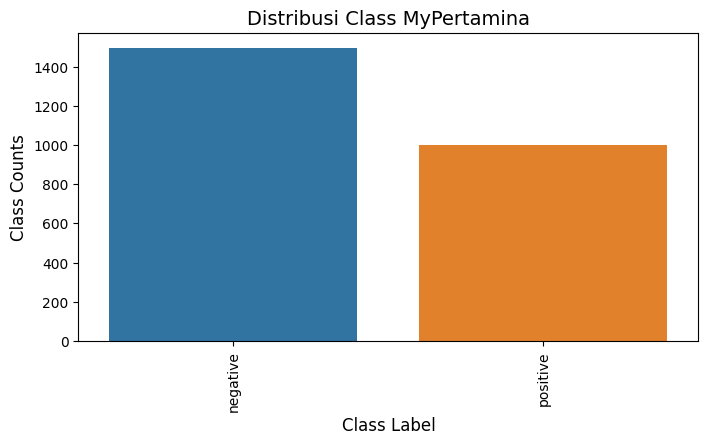

In [ ]:
# Cek jumlah review positive dan negative
plt.figure(figsize=(8,4))
sns.countplot(x="sentiment", data=data_raw)
plt.title('Distribusi Class MyPertamina', fontsize=14)
plt.ylabel('Class Counts', fontsize=12)
plt.xlabel('Class Label', fontsize=12)
plt.xticks(rotation='vertical');

# **PRE-PROCESSING**

### **CLEANING DATA**

In [ ]:
def cleaningText(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)     # Menghapus URL
    text = re.sub(r'@[A-Za-z0-9]+', '', text)             # remove mentions
    text = re.sub(r'#[A-Za-z0-9]+', '', text)             # remove hashtag
    text = re.sub(r'[-+]?[0-9]+', '', text)               # Menghapus angka
    text = re.sub(r'[^\w\s\"\']','', text)                # Menghapus karakter tanda baca
    text = re.sub(r'(.)\1+', r'\1\1', text)               # remove words repetition
    text = re.sub(r'\b(\w+)(?:\W\1\b)+', r'\1', text, flags=re.IGNORECASE)
    # text = text.strip()                                   # Menghapus whitespaces
    TEXT = re.sub(r'\s+',' ', text)
    text = text.replace('\n', ' ')                        # replace new line into space
    text = re.sub(r'RT[\s]', '', text)                    # remove RT
    # text = re.sub("[,.?!]", " ", text)
    # text = re.sub('[^A-Za-z0-9]+', ' ', text)
    # text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text)
    # text = re.sub("(.)\\1{2,}", "\\1", text)

    text = text.replace('\n', ' ') # replace new line into space
    text = text.translate(str.maketrans('', '', string.punctuation)) # remove all punctuations
    text = text.strip(' ') # remove characters space from both left and right text
    return text

In [ ]:
data_raw['cleaning'] = data_raw['content'].apply(cleaningText)

In [ ]:
def casefoldingText(text): # Converting all the characters in a text into lower case
    text = text.lower()
    return text

In [ ]:
data_raw['casefolding'] = data_raw['cleaning'].apply(casefoldingText)

In [ ]:
data_raw['casefolding']

0       pks kritik beli pertalite pakai mypertamina an...
1       terpaksa harus uninstal ini instagram soalnya ...
2       potret akibat dari pemerintah indonesia yang b...
3       per  juli  pertamina buka pendaftaran di websi...
4       bukannya belajar dari kesalahan masa lalu peme...
                              ...                        
2495    oh jadi soal beli solar dan pertalite pakai ap...
2496    halo sahabat rpkpt pertamina melalui anak usah...
2497    aplikasi mypertamina langkah maju menuju siste...
2498    dpr dukung penggunaan mypertamina untuk beli p...
2499    mypertamina di profil harus isi hobi tuh fungs...
Name: casefolding, Length: 2500, dtype: object

In [ ]:
data_raw

date        username  \
0     2022-06-29 23:59:34+00:00      tempodotco   
1     2022-06-29 23:59:18+00:00        butoable   
2     2022-06-29 23:57:06+00:00   crimsonandivy   
3     2022-06-29 23:54:17+00:00    KasanMulyono   
4     2022-06-29 23:53:37+00:00  edy_siregar_77   
...                         ...             ...   
2495  2022-06-29 09:08:22+00:00       ppaprikah   
2496  2022-06-29 09:06:23+00:00        963RPKFM   
2497  2022-06-29 09:06:19+00:00      kompasiana   
2498  2022-06-29 08:18:32+00:00       Bisniscom   
2499  2022-06-29 09:05:44+00:00          rachwz   

                                                content sentiment  \
0     PKS Kritik Beli Pertalite Pakai MyPertamina, A...  negative   
1     Terpaksa harus uninstal ini instagram, soalnya...  negative   
2     Potret akibat dari pemerintah Indonesia yang b...  negative   
3     Per 1 Juli 2022 Pertamina buka pendaftaran di ...  positive   
4     Bukannya belajar dari kesalahan masa lalu, pem...  negative   
...                                                 ...       ...   
2495  Oh jadi soal beli solar dan pertalite pakai ap...  positive   
2496  Halo Sahabat RPKüëãPT Pertamina melalui anak usa...  positive   
2497  Aplikasi MyPertamina, Langkah Maju Menuju Sist...  positive   
2498  DPR Dukung Penggunaan MyPertamina untuk Beli P...  positive   
2499  MyPertamina di profil harus isi hobi tuh fungs...  negative   

                                               cleaning  \
0     PKS Kritik Beli Pertalite Pakai MyPertamina An...   
1     Terpaksa harus uninstal ini instagram soalnya ...   
2     Potret akibat dari pemerintah Indonesia yang b...   
3     Per  Juli  Pertamina buka pendaftaran di websi...   
4     Bukannya belajar dari kesalahan masa lalu peme...   
...                                                 ...   
2495  Oh jadi soal beli solar dan pertalite pakai ap...   
2496  Halo Sahabat RPKPT Pertamina melalui anak usah...   
2497  Aplikasi MyPertamina Langkah Maju Menuju Siste...   
2498  DPR Dukung Penggunaan MyPertamina untuk Beli P...   
2499  MyPertamina di profil harus isi hobi tuh fungs...   

                                            casefolding  
0     pks kritik beli pertalite pakai mypertamina an...  
1     terpaksa harus uninstal ini instagram soalnya ...  
2     potret akibat dari pemerintah indonesia yang b...  
3     per  juli  pertamina buka pendaftaran di websi...  
4     bukannya belajar dari kesalahan masa lalu peme...  
...                                                 ...  
2495  oh jadi soal beli solar dan pertalite pakai ap...  
2496  halo sahabat rpkpt pertamina melalui anak usah...  
2497  aplikasi mypertamina langkah maju menuju siste...  
2498  dpr dukung penggunaan mypertamina untuk beli p...  
2499  mypertamina di profil harus isi hobi tuh fungs...  

[2500 rows x 6 columns]

### **NORMALIZATION PHASE**

In [ ]:
!gdown --id 1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y

slangs = open('slang.txt',"r",encoding="utf-8", errors='replace')

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1cXaOtuw6xqWL6KDjZqvkzGYsiyyr0X1y
To: /content/slang.txt
100% 32.8k/32.8k [00:00<00:00, 109MB/s]


In [ ]:
clear_slangs= []
for newlines in slangs:
  strip_re = newlines.strip("\n")
  split = re.split(r'[:]',strip_re)
  clear_slangs.append(split)

print(clear_slangs)

[['& ', ' dan'], ['dr ', ' dari'], ['abis ', ' habis'], ['ad ', ' ada'], ['alhmdulillah ', ' alhamdulillah'], ['alhamdulilah ', ' alhamdulillah'], ['alhamdulillaah ', ' alhamdulillah'], ['alhamdulillah ', ' alhamdulillah'], ['adminnya ', ' admin nya'], ['account ', ' akun'], ['asiikk ', ' asyik'], ['alpukatnya ', ' alpukat nya'], ['amin ', ' aamiin'], ['aplikasinnya ', ' aplikasi nya'], ['aplikasinya ', ' aplikasi nya'], ['awesome ', ' luar biasa'], ['asyilk ', ' asyik'], ['antaran ', ' pengantaran'], ['apus ', ' hapus'], ['ampe ', ' sampai'], ['almt ', ' alamat'], ['almat ', ' alamat'], ['alamt ', ' alamat'], ['almtnya ', ' alamatnya'], ['apknya ', ' aplikasinya'], ['antri ', ' antre'], ['adl ', ' adalah'], ['awalnnya ', ' awalnya'], ['asem ', ' asam'], ['alumunium ', ' aluminium'], ['abis ', ' habis'], ['areaku ', ' area saya'], ['alpulat ', ' alpukat'], ['adlah ', ' adalah'], ['applikasi ', ' aplikasi'], ['apps ', ' aplikasi'], ['app ', ' aplikasi'], ['afordable ', ' affordable'], [

In [ ]:
slangs = [[k.strip(), v.strip()] for k,v in clear_slangs]
dict_slangs = {key:values for key,values in slangs}
dict_slangs

{'&': 'dan',
 'dr': 'dari',
 'abis': 'habis',
 'ad': 'ada',
 'alhmdulillah': 'alhamdulillah',
 'alhamdulilah': 'alhamdulillah',
 'alhamdulillaah': 'alhamdulillah',
 'alhamdulillah': 'alhamdulillah',
 'adminnya': 'admin nya',
 'account': 'akun',
 'asiikk': 'asyik',
 'alpukatnya': 'alpukat nya',
 'amin': 'aamiin',
 'aplikasinnya': 'aplikasi nya',
 'aplikasinya': 'aplikasi nya',
 'awesome': 'luar biasa',
 'asyilk': 'asyik',
 'antaran': 'pengantaran',
 'apus': 'hapus',
 'ampe': 'sampai',
 'almt': 'alamat',
 'almat': 'alamat',
 'alamt': 'alamat',
 'almtnya': 'alamatnya',
 'apknya': 'aplikasinya',
 'antri': 'antre',
 'adl': 'adalah',
 'awalnnya': 'awalnya',
 'asem': 'asam',
 'alumunium': 'aluminium',
 'areaku': 'area saya',
 'alpulat': 'alpukat',
 'adlah': 'adalah',
 'applikasi': 'aplikasi',
 'apps': 'aplikasi',
 'app': 'aplikasi',
 'afordable': 'affordable',
 'agent': 'agen',
 'agus': 'hangus',
 'apk': 'aplikasi',
 'appsnya': 'aplikasinya',
 'aah': 'ah',
 'apakh': 'apakah',
 'apalgi': 'apal

In [ ]:
clean_text = []
for review in data_raw['casefolding']:
  wordlist = TextBlob(review).words
  for k,v in enumerate(wordlist):
    if v in dict_slangs.keys():
      wordlist[k] = dict_slangs[v]
  clean_text.append(' '.join(wordlist))

In [ ]:
clean_text

['pks kritik beli pertalite pakai mypertamina anggap merepotkan konsumen',
 'terpaksa harus hapus instalan ini instagram soalnya harus memasang mypertamina',
 'potret akibat dari pemerintah indonesia yang bisanya nyusahin rakyat saja tolak pembelian pertalite dan solar dengan mypertamina tolak pembelian minyak goreng pedulilindungi berbasis nik',
 'per juli pertamina buka pendaftaran di website mypertamina begini caranya dan kenali manfaatnya',
 'bukannya belajar dari kesalahan masa lalu pemerintah bahkan mengeluarkan jurus terbaru mengendalikan konsumsi bbm bersubsidi lewat aplikasi mypertamina membuat kebijakan itu seharusnya mempermudah bukan sebaliknya semakin menyusahkan rakyat hanya untuk membeli bbm bersubsidi',
 'aplikasi mypertamina untuk beli gas lpg kg masih wacana lewat',
 'orang pada kritik keputusan mypertamina namanya juga perubahan awalnya pasti tidak terbiasa kayak pas awal dahulu krl harus punya emoney',
 'pembelian pertalite dan solar akan diperketat dengan cara mewa

In [ ]:
data_raw['normalization'] = clean_text

In [ ]:
#delete words containing 3 letters
def remove_small_words(text):
  text = re.sub(r'\b\w{1,3}\b','',text)
  return text

In [ ]:
data_raw['normalization'] = data_raw['normalization'].apply(remove_small_words)

In [ ]:
data_raw

date        username  \
0     2022-06-29 23:59:34+00:00      tempodotco   
1     2022-06-29 23:59:18+00:00        butoable   
2     2022-06-29 23:57:06+00:00   crimsonandivy   
3     2022-06-29 23:54:17+00:00    KasanMulyono   
4     2022-06-29 23:53:37+00:00  edy_siregar_77   
...                         ...             ...   
2495  2022-06-29 09:08:22+00:00       ppaprikah   
2496  2022-06-29 09:06:23+00:00        963RPKFM   
2497  2022-06-29 09:06:19+00:00      kompasiana   
2498  2022-06-29 08:18:32+00:00       Bisniscom   
2499  2022-06-29 09:05:44+00:00          rachwz   

                                                content sentiment  \
0     PKS Kritik Beli Pertalite Pakai MyPertamina, A...  negative   
1     Terpaksa harus uninstal ini instagram, soalnya...  negative   
2     Potret akibat dari pemerintah Indonesia yang b...  negative   
3     Per 1 Juli 2022 Pertamina buka pendaftaran di ...  positive   
4     Bukannya belajar dari kesalahan masa lalu, pem...  negative   
...                                                 ...       ...   
2495  Oh jadi soal beli solar dan pertalite pakai ap...  positive   
2496  Halo Sahabat RPKüëãPT Pertamina melalui anak usa...  positive   
2497  Aplikasi MyPertamina, Langkah Maju Menuju Sist...  positive   
2498  DPR Dukung Penggunaan MyPertamina untuk Beli P...  positive   
2499  MyPertamina di profil harus isi hobi tuh fungs...  negative   

                                               cleaning  \
0     PKS Kritik Beli Pertalite Pakai MyPertamina An...   
1     Terpaksa harus uninstal ini instagram soalnya ...   
2     Potret akibat dari pemerintah Indonesia yang b...   
3     Per  Juli  Pertamina buka pendaftaran di websi...   
4     Bukannya belajar dari kesalahan masa lalu peme...   
...                                                 ...   
2495  Oh jadi soal beli solar dan pertalite pakai ap...   
2496  Halo Sahabat RPKPT Pertamina melalui anak usah...   
2497  Aplikasi MyPertamina Langkah Maju Menuju Siste...   
2498  DPR Dukung Penggunaan MyPertamina untuk Beli P...   
2499  MyPertamina di profil harus isi hobi tuh fungs...   

                                            casefolding  \
0     pks kritik beli pertalite pakai mypertamina an...   
1     terpaksa harus uninstal ini instagram soalnya ...   
2     potret akibat dari pemerintah indonesia yang b...   
3     per  juli  pertamina buka pendaftaran di websi...   
4     bukannya belajar dari kesalahan masa lalu peme...   
...                                                 ...   
2495  oh jadi soal beli solar dan pertalite pakai ap...   
2496  halo sahabat rpkpt pertamina melalui anak usah...   
2497  aplikasi mypertamina langkah maju menuju siste...   
2498  dpr dukung penggunaan mypertamina untuk beli p...   
2499  mypertamina di profil harus isi hobi tuh fungs...   

                                          normalization  
0      kritik beli pertalite pakai mypertamina angga...  
1     terpaksa harus hapus instalan  instagram soaln...  
2     potret akibat dari pemerintah indonesia yang b...  
3      juli pertamina buka pendaftaran  website mype...  
4     bukannya belajar dari kesalahan masa lalu peme...  
...                                                 ...  
2495   jadi soal beli solar  pertalite pakai aplikas...  
2496  halo sahabat rpkpt pertamina melalui anak usah...  
2497  aplikasi mypertamina langkah maju menuju siste...  
2498   dukung penggunaan mypertamina untuk beli pert...  
2499  mypertamina  profil harus  hobi  fungsinya bua...  

[2500 rows x 7 columns]

### **TOKENIZING, STEMMING, AND STOPWORD REMOVAL**

In [ ]:
!pip install sastrawi

In [ ]:
def word_tokenize(text):
    text = nltk.tokenize.word_tokenize(text)
    return text

data_raw['tokenizing'] = data_raw['normalization'].apply(word_tokenize)

In [ ]:
data_raw['tokenizing']

0       [kritik, beli, pertalite, pakai, mypertamina, ...
1       [terpaksa, harus, hapus, instalan, instagram, ...
2       [potret, akibat, dari, pemerintah, indonesia, ...
3       [juli, pertamina, buka, pendaftaran, website, ...
4       [bukannya, belajar, dari, kesalahan, masa, lal...
                              ...                        
2495    [jadi, soal, beli, solar, pertalite, pakai, ap...
2496    [halo, sahabat, rpkpt, pertamina, melalui, ana...
2497    [aplikasi, mypertamina, langkah, maju, menuju,...
2498    [dukung, penggunaan, mypertamina, untuk, beli,...
2499    [mypertamina, profil, harus, hobi, fungsinya, ...
Name: tokenizing, Length: 2500, dtype: object

In [ ]:
def freqDist_wrapper(text):
    return FreqDist(text)

data_raw['freq'] = data_raw['tokenizing'].apply(freqDist_wrapper)

In [ ]:
data_raw['freq']

0       {'kritik': 1, 'beli': 1, 'pertalite': 1, 'paka...
1       {'terpaksa': 1, 'harus': 2, 'hapus': 1, 'insta...
2       {'potret': 1, 'akibat': 1, 'dari': 1, 'pemerin...
3       {'juli': 1, 'pertamina': 1, 'buka': 1, 'pendaf...
4       {'bukannya': 1, 'belajar': 1, 'dari': 1, 'kesa...
                              ...                        
2495    {'jadi': 1, 'soal': 1, 'beli': 1, 'solar': 1, ...
2496    {'halo': 1, 'sahabat': 1, 'rpkpt': 1, 'pertami...
2497    {'aplikasi': 1, 'mypertamina': 1, 'langkah': 1...
2498    {'dukung': 1, 'penggunaan': 1, 'mypertamina': ...
2499    {'mypertamina': 1, 'profil': 1, 'harus': 1, 'h...
Name: freq, Length: 2500, dtype: object

In [ ]:
import Sastrawi
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
factory = StopWordRemoverFactory()
stopwords = factory.get_stop_words()
print(stopwords)

['yang', 'untuk', 'pada', 'ke', 'para', 'namun', 'menurut', 'antara', 'dia', 'dua', 'ia', 'seperti', 'jika', 'jika', 'sehingga', 'kembali', 'dan', 'tidak', 'ini', 'karena', 'kepada', 'oleh', 'saat', 'harus', 'sementara', 'setelah', 'belum', 'kami', 'sekitar', 'bagi', 'serta', 'di', 'dari', 'telah', 'sebagai', 'masih', 'hal', 'ketika', 'adalah', 'itu', 'dalam', 'bisa', 'bahwa', 'atau', 'hanya', 'kita', 'dengan', 'akan', 'juga', 'ada', 'mereka', 'sudah', 'saya', 'terhadap', 'secara', 'agar', 'lain', 'anda', 'begitu', 'mengapa', 'kenapa', 'yaitu', 'yakni', 'daripada', 'itulah', 'lagi', 'maka', 'tentang', 'demi', 'dimana', 'kemana', 'pula', 'sambil', 'sebelum', 'sesudah', 'supaya', 'guna', 'kah', 'pun', 'sampai', 'sedangkan', 'selagi', 'sementara', 'tetapi', 'apakah', 'kecuali', 'sebab', 'selain', 'seolah', 'seraya', 'seterusnya', 'tanpa', 'agak', 'boleh', 'dapat', 'dsb', 'dst', 'dll', 'dahulu', 'dulunya', 'anu', 'demikian', 'tapi', 'ingin', 'juga', 'nggak', 'mari', 'nanti', 'melainkan', '

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

list_stopwords = stopwords.words('indonesian')

list_stopwords.extend(['jd', 'yg', 'wkwkwkwk', 'wkwk', 'wkwkwk', 'wkwkk', 'gw', 'jg',
                       'dg', 'yah', 'jir', 'anjir', 'anjirr','amp', 'trs', 'td', 'goblok',
                       'goblox', 'aq', 'kl', 'sajak', 'stlh', 'kudu', 'trus', 'ahayy'])

txt_stopword = pd.read_excel('/content/gdrive/MyDrive/Skripsi/Dataset/datalabel_angka.xlsx', names = ['stopwords'], header = None)

list_stopwords.extend(txt_stopword['stopwords'][0].split(' '))

list_stopwords = set(list_stopwords)

def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

data_raw['stopword'] = data_raw['tokenizing'].apply(stopwords_removal)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data_raw['stopword']

0       [kritik, beli, pertalite, pakai, mypertamina, ...
1       [terpaksa, hapus, instalan, instagram, memasan...
2       [potret, akibat, pemerintah, indonesia, bisany...
3       [juli, pertamina, buka, pendaftaran, website, ...
4       [belajar, kesalahan, pemerintah, mengeluarkan,...
                              ...                        
2495    [beli, solar, pertalite, pakai, aplikasi, mype...
2496    [halo, sahabat, rpkpt, pertamina, anak, usahan...
2497    [aplikasi, mypertamina, langkah, maju, sistema...
2498    [dukung, penggunaan, mypertamina, beli, pertal...
2499               [mypertamina, profil, hobi, fungsinya]
Name: stopword, Length: 2500, dtype: object

In [ ]:
pip install Swifter

In [ ]:
import swifter
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# stemmed
def stemmingText(term):
    return stemmer.stem(term)

term_dict = {}

for document in data_raw['stopword']:
    for term in document:
        if term not in term_dict:
            term_dict[term] = ' '

print(len(term_dict))
print("------------------------")

for term in term_dict:
    term_dict[term] = stemmingText(term)
    print(term,":" ,term_dict[term])

print(term_dict)
print("------------------------")


# apply stemmed term to dataframe
def get_stemmed_term(document):
    return [term_dict[term] for term in document]

data_raw['stemming'] = data_raw['stopword'].swifter.apply(get_stemmed_term)
print(data_raw['stemming'])

Streaming output truncated to the last 5000 lines.
wilayah : wilayah
organda : organda
penerapan : terap
siapsiap : siapsiap
diperbarui : baru
server : server
overload : overload
bersamaan : sama
imbas : imbas
kotakab : kotakab
maaf : maaf
duar : duar
erorjalan : erorjalan
keluarnya : keluar
bagaimanakl : bagaimanakl
masukkan : masuk
nomor : nomor
desak : desak
cabut : cabut
kntd : kntd
bangsa : bangsa
maju : maju
judul : judul
marah : marah
curah : curah
bandar : bandar
mainin : mainin
quota : quota
export : export
tajir : tajir
jatah : jatah
peduli : peduli
lindungi : lindung
diwajibkan : wajib
ketersediaan : sedia
terbatas : batas
misi : misi
utama : utama
mandat : mandat
mengurusi : urus
ngurusin : ngurusin
konflik : konflik
buruan : buru
sumbar : sumbar
taubelum : taubelum
arahan : arah
kantor : kantor
mesinnya : mesin
lokasi : lokasi
bekasi : bekas
gass : gass
pool : pool
pilihan : pilih
pelanggan : langgan
gapapalah : gapapalah
naek : naek
bayangin : bayangin
uninstall : uninsta

Pandas Apply:   0%|          | 0/2500 [00:00<?, ?it/s]

0       [kritik, beli, pertalite, pakai, mypertamina, ...
1       [paksa, hapus, instalan, instagram, pasang, my...
2       [potret, akibat, perintah, indonesia, bisa, ny...
3       [juli, pertamina, buka, daftar, website, myper...
4       [ajar, salah, perintah, keluar, jurus, baru, k...
                              ...                        
2495    [beli, solar, pertalite, pakai, aplikasi, mype...
2496    [halo, sahabat, rpkpt, pertamina, anak, usaha,...
2497    [aplikasi, mypertamina, langkah, maju, sistema...
2498         [dukung, guna, mypertamina, beli, pertalite]
2499                  [mypertamina, profil, hobi, fungsi]
Name: stemming, Length: 2500, dtype: object


In [ ]:
data_raw.to_csv('/content/gdrive/MyDrive/Skripsi/Dataset/data_prepo.csv', index=False)

# **READ DATA AFTER PREPO**

In [ ]:
data = pd.read_csv('/content/gdrive/MyDrive/Skripsi/Dataset/data_prepo.csv')

In [ ]:
data

date        username  \
0     2022-06-29 23:59:34+00:00      tempodotco   
1     2022-06-29 23:59:18+00:00        butoable   
2     2022-06-29 23:57:06+00:00   crimsonandivy   
3     2022-06-29 23:54:17+00:00    KasanMulyono   
4     2022-06-29 23:53:37+00:00  edy_siregar_77   
...                         ...             ...   
2495  2022-06-29 09:08:22+00:00       ppaprikah   
2496  2022-06-29 09:06:23+00:00        963RPKFM   
2497  2022-06-29 09:06:19+00:00      kompasiana   
2498  2022-06-29 08:18:32+00:00       Bisniscom   
2499  2022-06-29 09:05:44+00:00          rachwz   

                                                content sentiment  \
0     PKS Kritik Beli Pertalite Pakai MyPertamina, A...  negative   
1     Terpaksa harus uninstal ini instagram, soalnya...  negative   
2     Potret akibat dari pemerintah Indonesia yang b...  negative   
3     Per 1 Juli 2022 Pertamina buka pendaftaran di ...  positive   
4     Bukannya belajar dari kesalahan masa lalu, pem...  negative   
...                                                 ...       ...   
2495  Oh jadi soal beli solar dan pertalite pakai ap...  positive   
2496  Halo Sahabat RPKüëãPT Pertamina melalui anak usa...  positive   
2497  Aplikasi MyPertamina, Langkah Maju Menuju Sist...  positive   
2498  DPR Dukung Penggunaan MyPertamina untuk Beli P...  positive   
2499  MyPertamina di profil harus isi hobi tuh fungs...  negative   

                                               cleaning  \
0     PKS Kritik Beli Pertalite Pakai MyPertamina An...   
1     Terpaksa harus uninstal ini instagram soalnya ...   
2     Potret akibat dari pemerintah Indonesia yang b...   
3     Per  Juli  Pertamina buka pendaftaran di websi...   
4     Bukannya belajar dari kesalahan masa lalu peme...   
...                                                 ...   
2495  Oh jadi soal beli solar dan pertalite pakai ap...   
2496  Halo Sahabat RPKPT Pertamina melalui anak usah...   
2497  Aplikasi MyPertamina Langkah Maju Menuju Siste...   
2498  DPR Dukung Penggunaan MyPertamina untuk Beli P...   
2499  MyPertamina di profil harus isi hobi tuh fungs...   

                                            casefolding  \
0     pks kritik beli pertalite pakai mypertamina an...   
1     terpaksa harus uninstal ini instagram soalnya ...   
2     potret akibat dari pemerintah indonesia yang b...   
3     per  juli  pertamina buka pendaftaran di websi...   
4     bukannya belajar dari kesalahan masa lalu peme...   
...                                                 ...   
2495  oh jadi soal beli solar dan pertalite pakai ap...   
2496  halo sahabat rpkpt pertamina melalui anak usah...   
2497  aplikasi mypertamina langkah maju menuju siste...   
2498  dpr dukung penggunaan mypertamina untuk beli p...   
2499  mypertamina di profil harus isi hobi tuh fungs...   

                                          normalization  \
0      kritik beli pertalite pakai mypertamina angga...   
1     terpaksa harus hapus instalan  instagram soaln...   
2     potret akibat dari pemerintah indonesia yang b...   
3      juli pertamina buka pendaftaran  website mype...   
4     bukannya belajar dari kesalahan masa lalu peme...   
...                                                 ...   
2495   jadi soal beli solar  pertalite pakai aplikas...   
2496  halo sahabat rpkpt pertamina melalui anak usah...   
2497  aplikasi mypertamina langkah maju menuju siste...   
2498   dukung penggunaan mypertamina untuk beli pert...   
2499  mypertamina  profil harus  hobi  fungsinya bua...   

                                             tokenizing  \
0     ['kritik', 'beli', 'pertalite', 'pakai', 'mype...   
1     ['terpaksa', 'harus', 'hapus', 'instalan', 'in...   
2     ['potret', 'akibat', 'dari', 'pemerintah', 'in...   
3     ['juli', 'pertamina', 'buka', 'pendaftaran', '...   
4     ['bukannya', 'belajar', 'dari', 'kesalahan', '...   
...                                                 ...   
2495  ['jadi', 'soal', 'beli', 'solar', 'p

# **TF-IDF**

In [ ]:
pip install pandas scikit-learn

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract the text data from a specific column in the DataFrame
text_data = data['stemming'].tolist()

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Transform the text data into TF-IDF features
result = vectorizer.fit_transform(text_data)

# Print the vocabulary (unique words)
print("Vocabulary:")
print(vectorizer.get_feature_names_out())

Vocabulary:
['aamiin' 'aampe' 'abadi' ... 'zona' 'zonasi' 'zone']


In [ ]:
# Menampilkan hasil vektor kata
print(result)

  (0, 1918)	0.3959033209519502
  (0, 3284)	0.47060084606194835
  (0, 140)	0.520556651877712
  (0, 2478)	0.08185164533018234
  (0, 2857)	0.16906827724228837
  (0, 3014)	0.21539713860890994
  (0, 382)	0.18189236398787792
  (0, 1959)	0.4858514615805166
  (1, 2903)	0.40088655870084605
  (1, 1512)	0.4877762616359791
  (1, 1513)	0.5004218029769117
  (1, 1358)	0.4457356192837961
  (1, 2867)	0.38345577844489104
  (1, 2478)	0.0722753652475879
  (2, 327)	0.3090435802350434
  (2, 2933)	0.2018984848618981
  (2, 1286)	0.21216449655155284
  (2, 2378)	0.19192122602154033
  (2, 3635)	0.1532332682656604
  (2, 3948)	0.5083535660973845
  (2, 3214)	0.1778280229157823
  (2, 2792)	0.25662507427837605
  (2, 473)	0.29463131840674056
  (2, 1487)	0.21128130164411282
  (2, 2999)	0.1807260752678742
  :	:
  (2496, 682)	0.16235359946184744
  (2496, 3695)	0.12088681663329752
  (2496, 727)	0.11808036556069605
  (2496, 3024)	0.26532007936865687
  (2496, 1652)	0.18723860877872844
  (2496, 3635)	0.14592199609595888
  (2

In [ ]:
print(f"Teks dokumen ke-{0+1}:\n{text_data[0]}")
print(f"Fitur Name ke-16: {vectorizer.get_feature_names_out()[1959]}")

Teks dokumen ke-1:
['kritik', 'beli', 'pertalite', 'pakai', 'mypertamina', 'anggap', 'repot', 'konsumen']
Fitur Name ke-16: kritik


In [ ]:
# Menampilkan hasil TF-IDF dalam bentuk list dua dimensi
result.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
# Membuat dataframe dari list dua dimensi tersebut.
# Dilakukan transpose agar nama kolom berubah menjadi nama baris
# Nama kolom diubah menjadi urutan dokumen
TF_IDF = pd.DataFrame(result.todense().T,
                  index=vectorizer.get_feature_names_out(),
                  columns=[f"D{i+1}" for i in range(len(text_data))])
TF_IDF

D1   D2   D3   D4   D5   D6   D7   D8   D9  D10  ...  D2491  D2492  \
aamiin  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
aampe   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
abadi   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
abai    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
abang   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
...     ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
yuyu    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
zaman   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
zona    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
zonasi  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   
zone    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...    0.0    0.0   

        D2493  D2494  D2495  D2496  D2497  D2498  D2499  D2500  
aamiin    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
aampe     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
abadi     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
abai      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
abang     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
...       ...    ...    ...    ...    ...    ...    ...    ...  
yuyu      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
zaman     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
zona      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
zonasi    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
zone      0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[4241 rows x 2500 columns]

# **SPLIT DATA**

In [ ]:
labels = data['sentiment'].tolist()

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(result, labels, test_size=0.1, random_state=15)

In [ ]:
y_train_2 = pd.DataFrame(y_train,  columns=['sentiment'])

In [ ]:
print(y_train_2["sentiment"].value_counts())

negative    1348
positive     902
Name: sentiment, dtype: int64


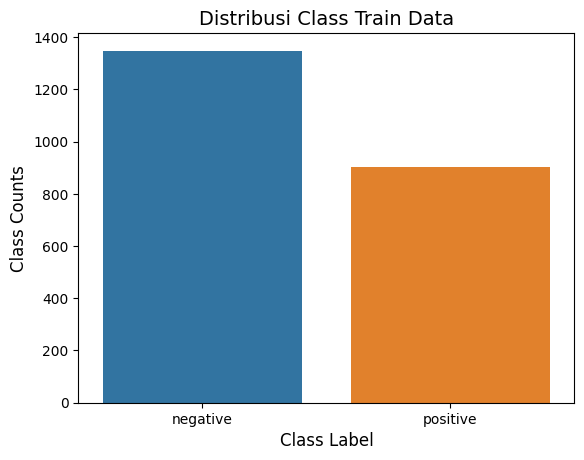

In [ ]:
# Get the elements and their counts from the Counter
sns.countplot(x="sentiment", data=y_train_2)

# Create a bar chart
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Class Counts', fontsize=12)
plt.title('Distribusi Class Train Data', fontsize=14)
plt.show()

# **SMOTE DATA**

In [ ]:
from collections import Counter
from imblearn.over_sampling import SMOTE

# summarize class distribution
print("Before oversampling: ",Counter(y_train))

# Apply SMOTE to the training data
smote = SMOTE()

# fit and apply the transform
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# summarize class distribution
sum_2 = Counter(y_train_over)
print("After oversampling: ",sum_2)

Before oversampling:  Counter({'negative': 1348, 'positive': 902})
After oversampling:  Counter({'negative': 1348, 'positive': 1348})


In [ ]:
y_train_over_2 = pd.DataFrame(y_train_over,  columns=['sentiment'])

In [ ]:
print(y_train_over_2["sentiment"].value_counts())

negative    1348
positive    1348
Name: sentiment, dtype: int64


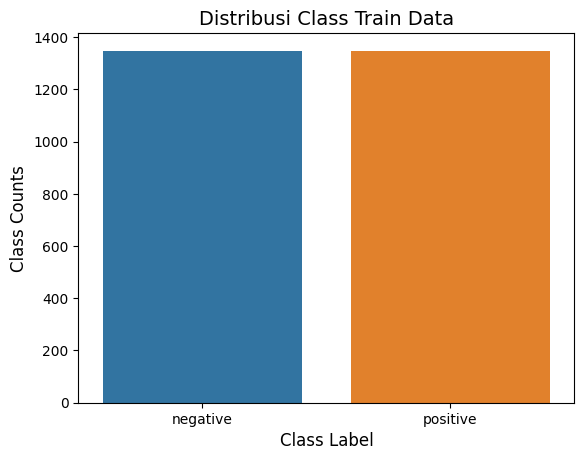

In [ ]:
from collections import Counter

# Get the elements and their counts from the Counter
sns.countplot(x="sentiment", data=y_train_over_2)

# Create a bar chart
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Class Counts', fontsize=12)
plt.title('Distribusi Class Train Data', fontsize=14)
plt.show()

# **MODELLING**

## **SUPPORT VECTOR MACHINE (SVM)**

In [ ]:
# create the classifier
svm_smote = SVC(probability=True)
t0_svm_smote = time.time()

# Train the classifier
svm_smote.fit(X_train_over, y_train_over)
t1_svm_smote = time.time()

# Make predictions on the test set
predictions_svm_smote = svm_smote.predict_proba(X_test)[:, 1]
t2_svm_smote = time.time()
time_train_svm_smote= t1_svm_smote-t0_svm_smote
time_predict_svm_smote = t2_svm_smote-t1_svm_smote

## **Naive Bayes Classifier**

In [ ]:
from sklearn.naive_bayes import BernoulliNB

In [ ]:
from sklearn.naive_bayes import BernoulliNB

#create classifier
nb_smote = BernoulliNB()
t0_nb_smote = time.time()

#train the classifier
nb_smote.fit(X_train_over, y_train_over)
t1_nb_smote = time.time()

predictions_nb_smote = nb_smote.predict_proba(X_test)[:, 1]
t2_nb_smote = time.time()
time_train_nb_smote = t1_nb_smote-t0_nb_smote
time_predict_nb_smote = t2_nb_smote-t1_nb_smote

# **RESULT & EVALUATION**

## **SVM**

In [ ]:
print("SVM with Oversampling")
print("Training time: %fs; Prediction time: %fs" % (time_train_svm_smote, time_predict_svm_smote))

# Hitung nilai akurasi
y_pred_svm_smote = svm_smote.predict(X_test)
accuracy_svm_smote = accuracy_score(y_test, y_pred_svm_smote)

print("")
print('Accuracy (SMOTE) = ', round(accuracy_svm_smote*100,2),'%')

SVM with Oversampling
Training time: 8.872362s; Prediction time: 0.244999s

Accuracy (SMOTE) =  84.8 %


In [ ]:
#show the classification report
print("Support Vector Machine")
print(classification_report(y_test,y_pred_svm_smote))

Support Vector Machine
              precision    recall  f1-score   support

    negative       0.82      0.97      0.88       151
    positive       0.93      0.67      0.78        99

    accuracy                           0.85       250
   macro avg       0.87      0.82      0.83       250
weighted avg       0.86      0.85      0.84       250



In [ ]:
fpr_svm_smote, tpr_svm_smote, thresholds_svm_smote = roc_curve(y_test, predictions_svm_smote, pos_label='positive')

In [ ]:
auc_score = auc(fpr_svm_smote, tpr_svm_smote)

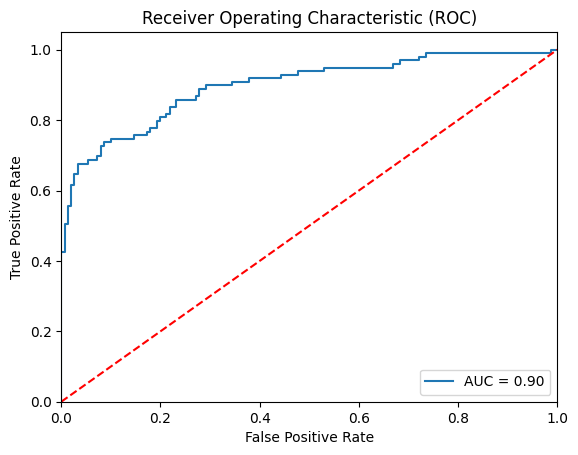

In [ ]:
plt.figure()
plt.plot(fpr_svm_smote, tpr_svm_smote, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

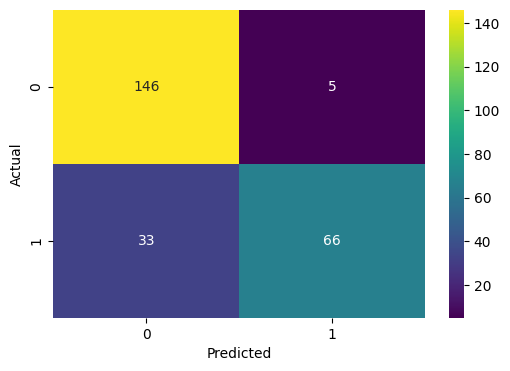

In [ ]:
#confussion matrix for svm
# Generate confusion matrix
cm_svm_smote = confusion_matrix(y_test, y_pred_svm_smote)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm_smote, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## **NAIVE BAYES**

In [ ]:
print("Training time: %fs; Prediction time: %fs" % (time_train_nb_smote, time_predict_nb_smote))

# Hitung nilai akurasi
y_pred_nb_smote = nb_smote.predict(X_test)
accuracy_nb_smote = accuracy_score(y_test, y_pred_nb_smote)

print("")
print('Accuracy  = ', round(accuracy_nb_smote*100,2),'%')

Training time: 0.019586s; Prediction time: 0.001424s

Accuracy  =  79.2 %


In [ ]:
fpr_nb_smote, tpr_nb_smote, thresholds_nb_smote = roc_curve(y_test, predictions_nb_smote, pos_label='positive')

In [ ]:
auc_score = auc(fpr_nb_smote, tpr_nb_smote)

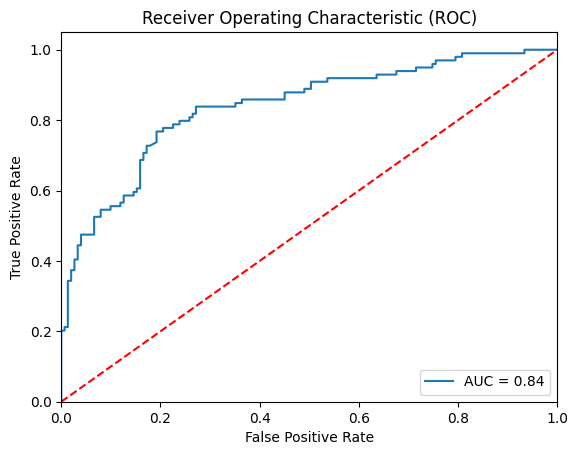

In [ ]:
plt.figure()
plt.plot(fpr_nb_smote, tpr_nb_smote, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
#show the classification report
print("Naive Bayes")
print(classification_report(y_test,y_pred_nb_smote))

Naive Bayes
              precision    recall  f1-score   support

    negative       0.84      0.81      0.82       151
    positive       0.72      0.77      0.75        99

    accuracy                           0.79       250
   macro avg       0.78      0.79      0.78       250
weighted avg       0.79      0.79      0.79       250



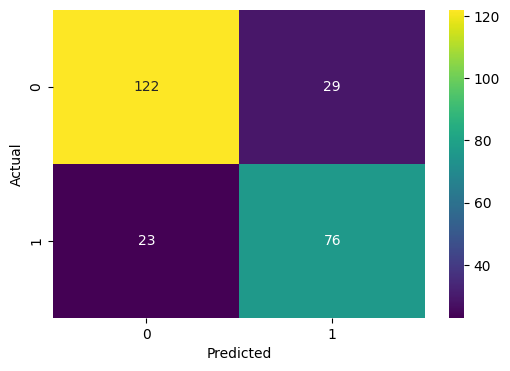

In [ ]:
#confussion matrix for nb
# Generate confusion matrix
cm_nb_smote = confusion_matrix(y_test, y_pred_nb_smote)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb_smote, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# **ADDITIONAL**

Mencari parameter untuk data splitting terbaik yang menghasilkan nilai akurasi paling tinggi dan meminimalisir model melakukan kesalahan prediksi

In [ ]:
X = data['stemming']
y = data['sentiment']

In [ ]:
test_num = []
random_num = []
acc_num = []
re_num = []
pre_num = []
matrix = []
report = []

for test in np.arange(0.1, 0.4, 0.1):
  for random in np.arange(0, 30, 5):
    print("test size:", test)
    print("random state:", random)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test, random_state=random)
    vectorizer = TfidfVectorizer(use_idf=True, smooth_idf=False)
    X_train_vect = vectorizer.fit_transform(X_train)
    X_test_vect = vectorizer.transform(X_test)
    SVM = SVC()
    SVM.fit(X_train_vect, y_train)
    print(SVM.score(X_train_vect, y_train))
    predict = SVM.predict(X_test_vect)
    accuracy = accuracy_score(y_test, predict)
    confusion = confusion_matrix(y_test, predict)
    print('confusion matrix:\n', confusion)
    classfication = print(classification_report(y_test, predict))
    print("Accuracy Score:", accuracy.round(2))
    recall = recall_score(y_test, predict, pos_label="positive")
    print("Recall Score:", recall)
    precision = precision_score(y_test, predict, pos_label="positive")
    print("Precision Score:", precision)
    print("\n")

    random_num.append(random)
    matrix.append(confusion)
    report.append(classfication)
    acc_num.append(accuracy)
    re_num.append(recall)
    pre_num.append(precision)
    test_num.append(test)
  print("=================================================================")

test size: 0.1
random state: 0
0.9737777777777777
confusion matrix:
 [[127  18]
 [ 39  66]]
              precision    recall  f1-score   support

    negative       0.77      0.88      0.82       145
    positive       0.79      0.63      0.70       105

    accuracy                           0.77       250
   macro avg       0.78      0.75      0.76       250
weighted avg       0.77      0.77      0.77       250

Accuracy Score: 0.77
Recall Score: 0.6285714285714286
Precision Score: 0.7857142857142857


test size: 0.1
random state: 5
0.9724444444444444
confusion matrix:
 [[125  19]
 [ 40  66]]
              precision    recall  f1-score   support

    negative       0.76      0.87      0.81       144
    positive       0.78      0.62      0.69       106

    accuracy                           0.76       250
   macro avg       0.77      0.75      0.75       250
weighted avg       0.77      0.76      0.76       250

Accuracy Score: 0.76
Recall Score: 0.6226415094339622
Precision Score:

In [ ]:
# memasukkan data ke dalam dataframe

data_split = {'test_size':test_num,
              'random_state':random_num,
              'confusion_matrix': matrix,
              'accuracy': acc_num,
              'recall': re_num,
              'precision': pre_num}

optimal = pd.DataFrame(data_split)
optimal
# optimal = optimal.sort_values(by=['accuracy','recall','precision'], ascending=True)

test_size  random_state         confusion_matrix  accuracy    recall  \
0         0.1             0    [[127, 18], [39, 66]]  0.772000  0.628571   
1         0.1             5    [[125, 19], [40, 66]]  0.764000  0.622642   
2         0.1            10    [[135, 12], [36, 67]]  0.808000  0.650485   
3         0.1            15    [[139, 12], [29, 70]]  0.836000  0.707071   
4         0.1            20    [[136, 16], [38, 60]]  0.784000  0.612245   
5         0.1            25    [[127, 23], [30, 70]]  0.788000  0.700000   
6         0.2             0   [[260, 30], [86, 124]]  0.768000  0.590476   
7         0.2             5   [[253, 37], [74, 136]]  0.778000  0.647619   
8         0.2            10   [[263, 28], [80, 129]]  0.784000  0.617225   
9         0.2            15   [[267, 25], [70, 138]]  0.810000  0.663462   
10        0.2            20   [[266, 37], [69, 128]]  0.788000  0.649746   
11        0.2            25   [[260, 39], [76, 125]]  0.770000  0.621891   
12        0.3             0  [[378, 40], [140, 193]]  0.760320  0.579580   
13        0.3             5  [[390, 55], [108, 198]]  0.782956  0.647059   
14        0.3            10  [[381, 57], [124, 189]]  0.758988  0.603834   
15        0.3            15  [[403, 38], [121, 189]]  0.788282  0.609677   
16        0.3            20  [[401, 52], [110, 188]]  0.784288  0.630872   
17        0.3            25  [[388, 60], [119, 184]]  0.761651  0.607261   
18        0.4             0  [[527, 53], [184, 236]]  0.763000  0.561905   
19        0.4             5  [[536, 70], [143, 251]]  0.787000  0.637056   
20        0.4            10  [[518, 71], [161, 250]]  0.768000  0.608273   
21        0.4            15  [[530, 57], [164, 249]]  0.779000  0.602906   
22        0.4            20  [[520, 67], [173, 240]]  0.760000  0.581114   
23        0.4            25  [[522, 77], [165, 236]]  0.758000  0.588529   

    precision  
0    0.785714  
1    0.776471  
2    0.848101  
3    0.853659  
4    0.789474  
5    0.752688  
6    0.805195  
7    0.786127  
8    0.821656  
9    0.846626  
10   0.775758  
11   0.762195  
12   0.828326  
13   0.782609  
14   0.768293  
15   0.832599  
16   0.783333  
17   0.754098  
18   0.816609  
19   0.781931  
20   0.778816  
21   0.813725  
22   0.781759  
23   0.753994